 # CLASSIFICATION MODEL

## Prepare Library, Parameters, and Dependencies

In [59]:
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import itertools
import pathlib
import os

%matplotlib inline

In [2]:
# UNCOMMENT THIS IF YOU USE GOOGLE COLAB

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Check TensorFlow Version and GPU Availability
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.15.0
Num GPUs Available:  1


In [4]:
# Set Parameters
TRAIN_DATASET_DIR = "/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/classification_datasets/roboflow_cataract_segmented_128_split/train/"
TEST_DATASET_DIR = "/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/classification_datasets/roboflow_cataract_segmented_128_split/test/"
TEST_PREDICT_DIR = "/content/drive/MyDrive/Skripsi/v_0.0.2/datasets/test_predict_seg/"
SAVE_MODEL_PATH = '/content/drive/MyDrive/Skripsi/v_0.0.2/models/classification_model_1/'

BATCH_SIZE = 32
VAL_RATIO = 0.2
SHUFFLE_BUFFER_SIZE = 1000

IMG_HEIGHT = 128
IMG_WIDTH = 128

SHUFFLE_VALUE = True
AUTOTUNE = tf.data.AUTOTUNE

## Model #1 (CNN Vanilla)

### Load & Split Dataset

In [5]:
# Create Training Dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DATASET_DIR,
    validation_split=VAL_RATIO,
    subset="training",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE,
)

# Create Validation Dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DATASET_DIR,
    validation_split=VAL_RATIO,
    subset="validation",
    seed=123,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE,
)

# Create Testing Dataset
test_ds = keras.utils.image_dataset_from_directory(
    directory=TEST_DATASET_DIR,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_VALUE,
)

Found 537 files belonging to 3 classes.
Using 430 files for training.
Found 537 files belonging to 3 classes.
Using 107 files for validation.
Found 60 files belonging to 3 classes.


['immature', 'mature', 'normal']


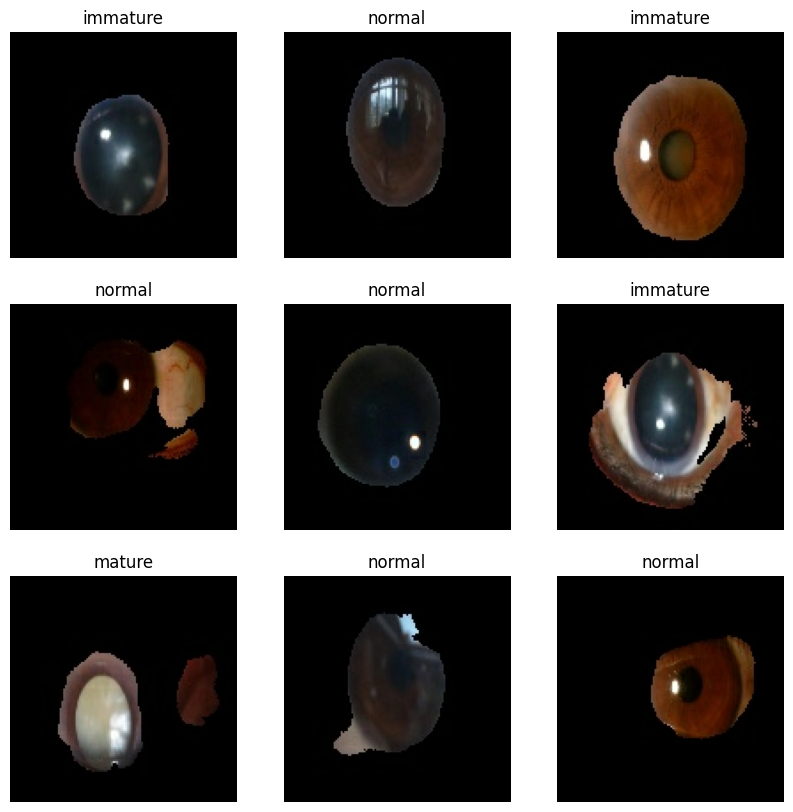

In [6]:
# Return Class Names from Dataset
class_names = train_ds.class_names
print(class_names)

# Visualize Classification Dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Normalize Data

In [7]:
# Normalize Function
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [8]:
# Apply normalization to the datasets
train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

### Data Augmentation

In [9]:
# Data Augmentation Function
def brightness(image, label):
    image = tf.image.adjust_brightness(image, 0.1)
    return image, label

def gamma(image, label):
    image = tf.image.adjust_gamma(image, 0.2)
    return image, label

def hue(image, mask):
    image = tf.image.adjust_hue(image, 0.2)
    return image, mask

def crop(image, label):
    image = tf.image.central_crop(image, 0.7)
    image = tf.image.resize(image, (IMG_HEIGHT, IMG_WIDTH))
    return image, label

def saturation(image, mask):
    image = tf.image.adjust_saturation(image, 0.5)
    return image, mask

In [10]:
# Check Train Count Before Augmentation
print(f'Number of training batches: {len(np.concatenate([i for x, i in train_ds]))}')

Number of training batches: 430


In [11]:
# Perform Data Augmentation
au_brightness = train_ds.map(brightness)
au_gamma = train_ds.map(gamma)
au_hue = train_ds.map(hue)
au_crop = train_ds.map(crop)
au_saturation = train_ds.map(saturation)

train_ds = train_ds.concatenate(au_brightness)
train_ds = train_ds.concatenate(au_gamma)
train_ds = train_ds.concatenate(au_hue)
train_ds = train_ds.concatenate(au_crop)
train_ds = train_ds.concatenate(au_saturation)

In [12]:
# Check Train Count After Augmentation
print(f'Number of training batches: {len(np.concatenate([i for x, i in train_ds]))}')

Number of training batches: 2580


### Dataset Pipelining

In [13]:
train_ds = train_ds.cache().shuffle(SHUFFLE_BUFFER_SIZE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Callbacks

In [39]:
# Checkpoint
checkpoint_path = 'model/my_checkpoint.ckpt'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)

### Model Architecture #1 (CNN Vanilla)

In [40]:
# Build Model
model = tf.keras.Sequential([
    keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(len(class_names))
])

In [41]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 65536)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

### Train Model #1

In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
model_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=100,
    callbacks=[checkpoint]
)

model.load_weights(checkpoint_path)

Epoch 1/100
82/84 [============================>.] - ETA: 0s - loss: 1.0539 - accuracy: 0.4436
Epoch 1: val_loss improved from inf to 0.95755, saving model to model/my_checkpoint.ckpt
84/84 [==============================] - 3s 19ms/step - loss: 1.0508 - accuracy: 0.4508 - val_loss: 0.9576 - val_accuracy: 0.6262
Epoch 2/100
82/84 [============================>.] - ETA: 0s - loss: 0.8553 - accuracy: 0.6435
Epoch 2: val_loss improved from 0.95755 to 0.73058, saving model to model/my_checkpoint.ckpt
84/84 [==============================] - 1s 16ms/step - loss: 0.8567 - accuracy: 0.6419 - val_loss: 0.7306 - val_accuracy: 0.7757
Epoch 3/100
81/84 [===========================>..] - ETA: 0s - loss: 0.7295 - accuracy: 0.6997
Epoch 3: val_loss improved from 0.73058 to 0.63641, saving model to model/my_checkpoint.ckpt
84/84 [==============================] - 1s 16ms/step - loss: 0.7256 - accuracy: 0.7008 - val_loss: 0.6364 - val_accuracy: 0.8037
Epoch 4/100
81/84 [===========================>..]

### Evaluate Model With Test Dataset

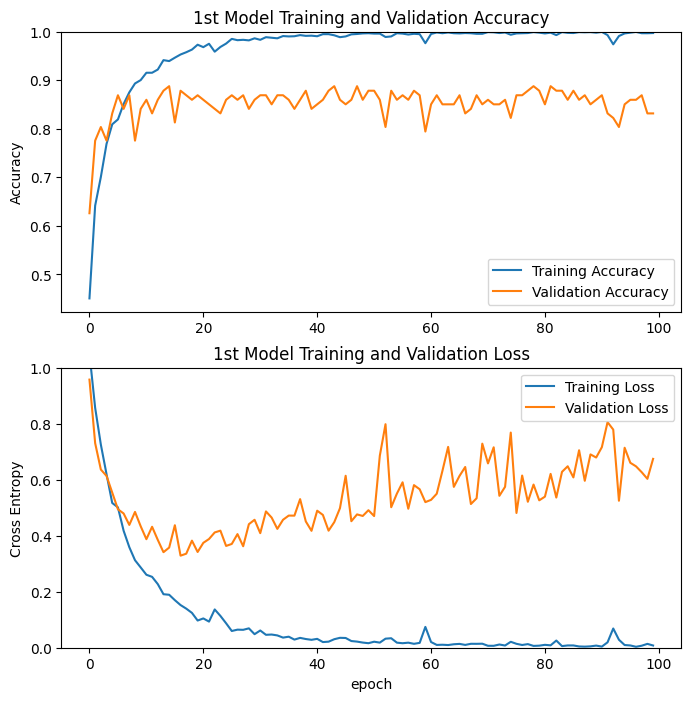

In [60]:
# Retrieve Accuracy and Loss from Classification Model
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

# Plot Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('1st Model Training and Validation Accuracy')

# Plot Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('1st Model Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [61]:
# Evaluate Model
loss, accuracy = model.evaluate(test_ds)

2/2 [==============================] - 0s 10ms/step - loss: 0.3651 - accuracy: 0.8500


In [62]:
# Retrieve a True Label from the Test Dataset
y_true = np.concatenate([i for x, i in test_ds])

# Make Prediction
y_pred = np.argmax(model.predict(test_ds), axis=-1)

# Plot Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

2/2 [==============================] - 0s 6ms/step


In [63]:
# Plot Function Confusion Matrix
def show_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black",
                     fontsize=15)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

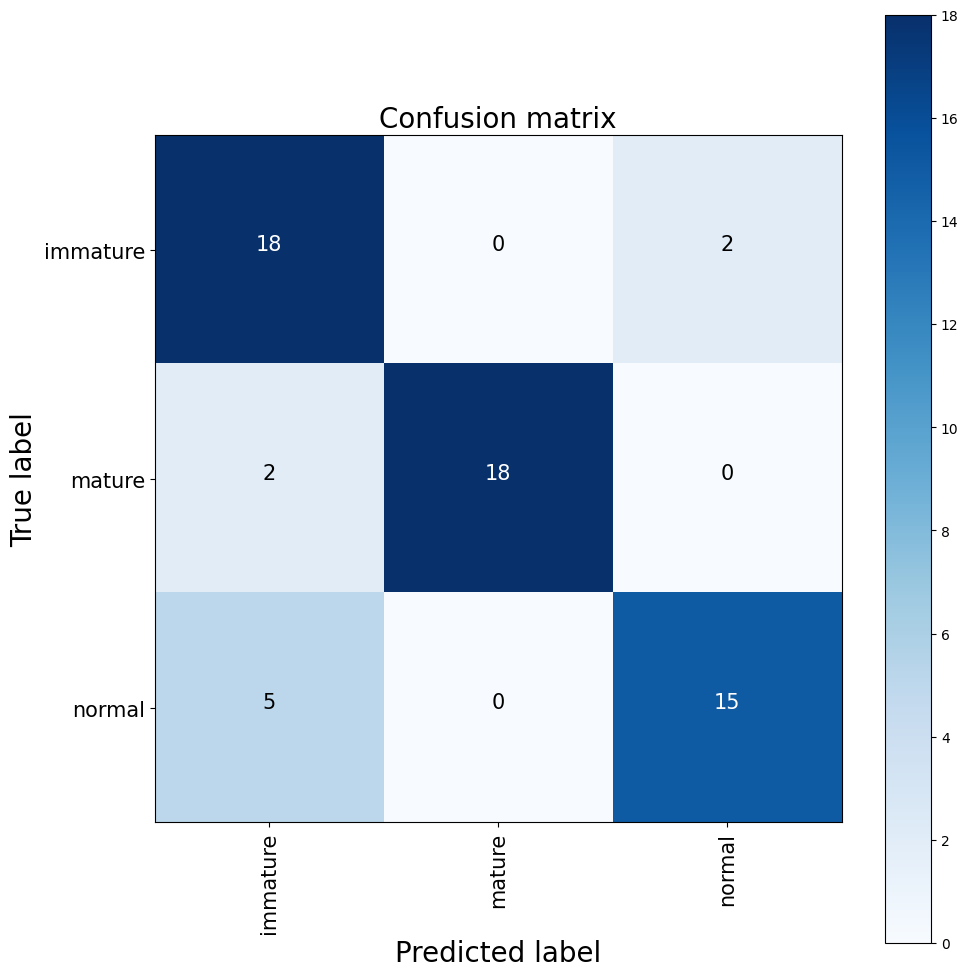

In [64]:
show_confusion_matrix(conf_mat, class_names)

In [65]:
# Classification Report (Accuracy, Precision, Recall, F1-Score)
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    immature       0.72      0.90      0.80        20
      mature       1.00      0.90      0.95        20
      normal       0.88      0.75      0.81        20

    accuracy                           0.85        60
   macro avg       0.87      0.85      0.85        60
weighted avg       0.87      0.85      0.85        60


### Test With Cataract Dataset

In [66]:
# Predict Sequential
predict_model = keras.Sequential([
    model,
    keras.layers.Softmax()
])

In [67]:
# Predict with Real Cataract Image
for filename in os.listdir(TEST_PREDICT_DIR):
    img = keras.preprocessing.image.load_img(TEST_PREDICT_DIR + filename, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = predict_model.predict(img_array)

    score = tf.nn.softmax(predictions[0])

    print(filename)
    print("This image most likely belongs to {} with a {:.2f} percent confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))
    print(predictions)

1/1 [==============================] - 0s 107ms/step
matur_seg1.jpg
This image most likely belongs to mature with a 57.61 percent confidence.
[[0. 1. 0.]]
1/1 [==============================] - 0s 17ms/step
normal_seg.jpg
This image most likely belongs to normal with a 57.61 percent confidence.
[[0.0000000e+00 4.6308856e-17 1.0000000e+00]]
1/1 [==============================] - 0s 16ms/step
imatur_seg.jpg
This image most likely belongs to immature with a 57.61 percent confidence.
[[1. 0. 0.]]
1/1 [==============================] - 0s 16ms/step
matur_seg3.jpg
This image most likely belongs to mature with a 57.61 percent confidence.
[[0. 1. 0.]]
1/1 [==============================] - 0s 17ms/step
matur_seg2.jpg
This image most likely belongs to mature with a 57.61 percent confidence.
[[0. 1. 0.]]
1/1 [==============================] - 0s 16ms/step
matur_seg4.jpg
This image most likely belongs to mature with a 57.61 percent confidence.
[[0. 1. 0.]]


## Save Model with TensorFlow Lite Converter

In [68]:
# Export Model to SavedModel Format
tf.saved_model.save(model, SAVE_MODEL_PATH)

# Convert SavedModel to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_saved_model(SAVE_MODEL_PATH)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the Model
tflite_model_file = pathlib.Path(SAVE_MODEL_PATH + 'model.tflite')
tflite_model_file.write_bytes(tflite_model)

16867428